# Patent Kaggle challenge

notebook from fastai course lesson 4

## Importing kaggle dataset

In [ ]:
!kaggle competitions download -c us-patent-phrase-to-phrase-matching 
!unzip us-patent-phrase-to-phrase-matching.zip -d us-patent-phrase-to-phrase-matching
!rm us-patent-phrase-to-phrase-matching.zip

In [1]:
from pathlib import Path

path = Path('us-patent-phrase-to-phrase-matching')
!ls {path}

sample_submission.csv  test.csv  train.csv


## Viewing data

In [2]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [3]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,8d135da0b55b8c88,component composite coating,composition,H01
freq,1,152,24,2186


In [4]:
df.target.value_counts()

target
composition               24
motor                     22
metal                     22
data                      22
assembly                  21
                          ..
switch over                1
switch off valve           1
switch control valve       1
supply valve               1
flow controlling valve     1
Name: count, Length: 29340, dtype: int64

In [5]:
df['section'] = df.context.str[0]
df.section.value_counts()

section
B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: count, dtype: int64

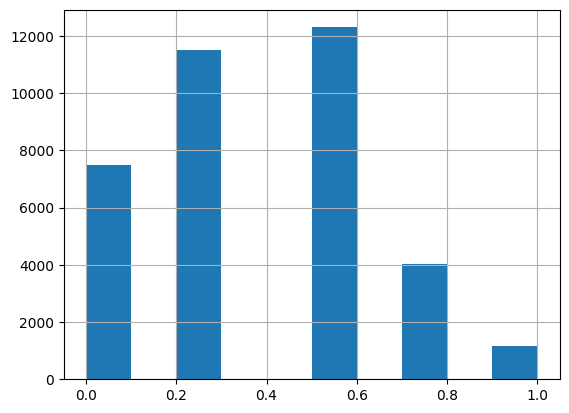

In [6]:
df.score.hist();

In [7]:
df[df.score==1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


In [8]:
df['input'] = 'TEXT1: ' + df.anchor + '; TEXT2: ' + df.target + '; CONTEXT: ' + df.context
df.input.head()

0    TEXT1: abatement; TEXT2: abatement of pollutio...
1    TEXT1: abatement; TEXT2: act of abating; CONTE...
2    TEXT1: abatement; TEXT2: active catalyst; CONT...
3    TEXT1: abatement; TEXT2: eliminating process; ...
4    TEXT1: abatement; TEXT2: forest region; CONTEX...
Name: input, dtype: object

## Tokenisation

In [9]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)
ds = ds.rename_columns({'score':'labels'})
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'section', 'input'],
    num_rows: 36473
})

In [10]:
model_nm = 'google-bert/bert-base-uncased'

In [11]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

In [12]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['g',
 "'",
 'day',
 'folks',
 ',',
 'i',
 "'",
 'm',
 'jeremy',
 'from',
 'fast',
 '.',
 'ai',
 '!']

In [13]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['a',
 'pl',
 '##at',
 '##yp',
 '##us',
 'is',
 'an',
 'or',
 '##ni',
 '##thor',
 '##hy',
 '##nch',
 '##us',
 'ana',
 '##tin',
 '##us',
 '.']

In [15]:
print(len(tokz.vocab))
print(tokz.vocab['of'])

30522
1997


In [16]:
print(ord('▁'))
print(ord('_'))

9601
95


In [17]:
tokz.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [19]:
sep = tokz.sep_token
sep

'[SEP]'

In [20]:
df['input'] = df.anchor + sep + df.target + sep + df.context
df.input.head()

0    abatement[SEP]abatement of pollution[SEP]A47
1            abatement[SEP]act of abating[SEP]A47
2           abatement[SEP]active catalyst[SEP]A47
3       abatement[SEP]eliminating process[SEP]A47
4             abatement[SEP]forest region[SEP]A47
Name: input, dtype: object

In [21]:
def tok_func(x): return tokz(x["input"])
tok_ds = ds.map(tok_func, batched=True, 
               remove_columns=('id', 'anchor', 'target', 'context', 'input', 'section'))
tok_ds

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [22]:
tok_ds[0]

{'labels': 0.5,
 'input_ids': [101,
  3793,
  2487,
  1024,
  19557,
  18532,
  4765,
  1025,
  3793,
  2475,
  1024,
  19557,
  18532,
  4765,
  1997,
  10796,
  1025,
  6123,
  1024,
  1037,
  22610,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

Test Set 

In [23]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


In [43]:
eval_df['input'] = eval_df.anchor + sep + eval_df.target + sep + eval_df.context
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True, remove_columns=('id', 'anchor', 'target', 'context', 'input'))

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

### Validation and Test data

Validation dataset

In [24]:
# method 1 : randomly pick items from the training data
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

method 2 : randomly select anchor values and pick all rows with this anchor values.

This way, anchor values do not overlap btween validation and training dataset

In [25]:
anchors = df.anchor.unique()
anchors[:10]

array(['abatement', 'abnormal position', 'absorbent properties', 'acan',
       'accept information', 'achieve authentication', 'acid absorption',
       'ack', 'acoustooptic modulator', 'acrylate groups'], dtype=object)

In [26]:
import numpy as np
np.random.shuffle(anchors)
anchors[:10]

array(['cervical support', 'rear adjustment',
       'average power ratio reduction', 'output center', 'weldability',
       'inner peripheral', 'contain bacterial cells', 'sawtooth waves',
       'resilient spring clip', 'tunneling capacitor'], dtype=object)

In [34]:
# proportion of distinct anchor values in the validation dataset
val_prop = 0.25

# number of distinct anchor values in the validation dataset
val_sz = int(len(anchors)*val_prop)

# list of anchor values in the validation dataset
val_anchors = anchors[:val_sz]

# boolean variable indicating whether an observation corresponds to a validation anchor value
is_val = df.anchor.isin(val_anchors)

# lists of rows in the validation dataset and in the train dataset
idxs = np.arange(len(df))
val_idxs = idxs[is_val]
trn_idxs = idxs[~is_val]



In [35]:
len(val_idxs),len(trn_idxs)

(9204, 27269)

In [37]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})


In [41]:
df.iloc[trn_idxs].score.mean().round(2), df.iloc[val_idxs].score.mean().round(2)

(np.float64(0.36), np.float64(0.36))

## Metric

Transformers expect metrics to be returnes as a dictionnary

In [44]:
import numpy as np
def corr(x,y): return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

In [45]:
from transformers import TrainingArguments,Trainer

In [46]:
bs = 128
epochs = 4
lr = 8e-5
wd = 0.01

def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        eval_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')

    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [52]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        eval_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:

model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [51]:
trainer = get_trainer(dds)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [50]:
!pip install 'accelerate>=0.26.0'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
trainer.train();

## Predictions

In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds = np.clip(preds, 0, 1)
print(preds)

In [ ]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)